# A Time Series Regression Analysis: Building Classification Models to Predict The Demands of Product

### **Problem Statement**

Corporation Favorita, a prominent a large Ecuadorian-based grocery retailer, aims to ensure that they always have the right quantity of products in stock. To acheive this as a data scientist in Corporation Favorita, we will build a series of machine learning models to forecast the demand of products in various locations.

### **Objective**
The primary objective of this project is to develop a robust time series regression model that more accurately predicts the unit sales for thousands of items. Importantfor Corporation Favorita’s various products across its different store locations. The model should account for historical sales data, promotional activities, holidays, and other relevant factors that influence sales.

### **Expected Impact**
By developing an accurate sales forecasting model, Corporation Favorita can better manage its inventory, reduce stockouts and overstock situations, and enhance overall customer satisfaction. This project will contribute to the company’s strategic planning and operational efficiency, ultimately driving higher profitability and growth.

### BUSINESS UNDERSTANDING

#### **Project Goal**: The aim of the project is to build a classification model that will forecast the demands of products in various locations.





**Null Hypothesis (H₀):** There is no significant relationship between historical sales data, promotional activities, holidays, and other external factors, and the future sales of Corporation Favorita's products.

**Alternative Hypothesis (H₁):** There is a significant relationship between historical sales data, promotional activities, holidays, and other external factors, and the future sales of Corporation Favorita's products.

### **Analytical Questions**

1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine which month of which year had the highest sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store

In [3]:

import numpy as np
import pandas as pd
import pyodbc
from dotenv import dotenv_values

import statsmodels.api as sm
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")


In [5]:
# use f sring to connect to the database.
connection_string=f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [6]:
# Use the connect method of the pyodbc library and pass in the connection string.
connection=pyodbc.connect(connection_string)

## Data Understanding
The data for this projects has been divided into 3. 

From an SQL database management system, three tables are contained.
Within the OneDrive, two files which are just for testing and not training.
Finally, contained in a GitHub repository are additional files.


In [7]:
# Write SQL Query to get data from the database.
query="Select * from dbo.oil"
oil = pd.read_sql(query,connection)

# Display the first 5 rows of the data

oil.head(5)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [8]:
query="Select * from dbo.holidays_events"
holidays_events = pd.read_sql(query,connection)

# Display the first 5 rows of the data

holidays_events.head(5)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [9]:
query="Select * from dbo.stores"
stores = pd.read_sql(query,connection)

# Display the first 5 rows of the data

stores.head(5)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [10]:
train = pd.read_csv(r"C:\Users\user\Documents\New folder\LP.3\store-sales-forecasting\train.csv")
# Display the first 5 rows of the data
train.head(5) 


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [11]:
transactions = pd.read_csv(r"C:\Users\user\Documents\New folder\LP.3\store-sales-forecasting\transactions.csv")

# Display the first 5 rows of the data

transactions.head(5)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [12]:
# Create a dictionary of the datasets
data = {'holiday': holidays_events, 'stores': stores, 'oil': oil, 'transactions': transactions, 'train': train}



In [13]:
# Check the datatypes and presence of missing values in each of the datasets
# Using '\033[1mtext\033[0m' to make text bold
for df_name, dataset in data.items():
    print(f'\033[1mFor {df_name} dataset\033[0m:')
    dataset.info()
    print('_'*45)
    print('\n')


For holiday dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
_____________________________________________


For stores dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
____

In [14]:
# Check the shape, and the presence of missing values and duplicates in each of the datasets
# Use '\033[1mtext\033[0m' to make text bold
for df_name, dataset in data.items():
    print(f'\033[1mFor {df_name} dataset\033[0m')
    print(f'Shape: {dataset.shape}')
    print(f'Missing values = {dataset.isna().sum().sum()}')
    print(f'Duplicates = {dataset.duplicated().sum()}')
    print('_'*30)
    print('\n')


For holiday dataset
Shape: (350, 6)
Missing values = 0
Duplicates = 0
______________________________


For stores dataset
Shape: (54, 5)
Missing values = 0
Duplicates = 0
______________________________


For oil dataset
Shape: (1218, 2)
Missing values = 43
Duplicates = 0
______________________________


For transactions dataset
Shape: (83488, 3)
Missing values = 0
Duplicates = 0
______________________________


For train dataset
Shape: (3000888, 6)
Missing values = 0
Duplicates = 0
______________________________




### Key Observations
- The only column with missing values is "dcoilwtico" from the oil dataset, which has 43 missing values 
 - All the date columns in the dataset are all in obect format
 - There are no duplicates in the dataset.
 - There is no column to identify the days in which there were holidays and days in which there were no holidays.

#### **Merge the datasets based on common columns**

In [15]:
# Merge transactions dataset to train on 'date' and 'store_nbr' columns
df1 = pd.merge(train, transactions, on=['date', 'store_nbr'], how='left')

# Merge holiday dataset to df1 on 'date' column
df2 = pd.merge(df1, holidays_events, on='date', how='left')

# Merge oil dataset to df2 on 'date' column
df3 = pd.merge(df2, oil, on='date', how='left')
df3

# Merge store dataset to df3 on 'store_nbr' column
df4 = pd.merge(df3, stores, on='store_nbr', how='left')

df4.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,type_x,locale,locale_name,description,transferred,dcoilwtico,city,state,type_y,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13


#### **Exploratory Analysis**

In [16]:
# Check for missing values after merging the datasets

df4.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
transactions     249117
type_x          2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dcoilwtico       955152
city                  0
state                 0
type_y                0
cluster               0
dtype: int64

The reason for the huge missing values is becuase there are dates with values on a dataset that are not represented at all on another dataset so when these datasets are merged, the rows of such dates will have missing values. 

In [17]:
# Check for duplicates after merging the datasets

df4.duplicated().sum()

0

In [18]:
# Drop the 'id' column as it is unnecessary for the analysis.

df4.drop(columns=['id'], inplace=True)

In [19]:
# Check the the columns of the dataset and there data types.
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 16 columns):
 #   Column        Dtype  
---  ------        -----  
 0   date          object 
 1   store_nbr     int64  
 2   family        object 
 3   sales         float64
 4   onpromotion   int64  
 5   transactions  float64
 6   type_x        object 
 7   locale        object 
 8   locale_name   object 
 9   description   object 
 10  transferred   object 
 11  dcoilwtico    float64
 12  city          object 
 13  state         object 
 14  type_y        object 
 15  cluster       int64  
dtypes: float64(3), int64(3), object(10)
memory usage: 372.8+ MB


In [20]:
# Check the features of 'type_x' column to what it contains.

df4['type_x'].unique()

array(['Holiday', nan, 'Work Day', 'Additional', 'Event', 'Transfer',
       'Bridge'], dtype=object)

The column contains holiday type and will be renamed to holiday_type.

In [21]:
# Check the features of 'type_y' column to what it contains.

df4['type_y'].unique()

array(['D', 'C', 'B', 'E', 'A'], dtype=object)

This column contains store type and will be renamed to store_type.

In [22]:
# Rename 'type_x', 'dcoilwtico' and type_y' to 'holiday_type', 'oil_price' and 'store_type' respectively

df4.rename(columns={'type_x': 'holiday_type', 'dcoilwtico': 'oil_price', 'type_y':'store_type'}, inplace=True)

df4 

,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,transferred,oil_price,city,state,store_type,cluster
0,2013-01-01,1,AUTOMOTIVE,0.000,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
1,2013-01-01,1,BABY CARE,0.000,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
2,2013-01-01,1,BEAUTY,0.000,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
3,2013-01-01,1,BEVERAGES,0.000,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
4,2013-01-01,1,BOOKS,0.000,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,2017-08-15,9,POULTRY,438.133,0,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6
3054344,2017-08-15,9,PREPARED FOODS,154.553,1,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6
3054345,2017-08-15,9,PRODUCE,2419.729,148,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6
3054346,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6


In [23]:
# check for missing values in each column.

df4.isnull().sum()

date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
transactions     249117
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
oil_price        955152
city                  0
state                 0
store_type            0
cluster               0
dtype: int64

In [24]:
# Filling the transactions column.

df4['transactions'].fillna(0, inplace=True)


In [25]:
# Fill the missing values in holiday_type, locale, locale_name, description and transferred 
# columns with 'No holiday' because these columns are from the holiday dataset, and they 
# represent the days where there were no holidays.

columns_to_fill = ['holiday_type', 'locale', 'locale_name', 'description', 'transferred']
for column in columns_to_fill:
        df4[column].fillna('No holiday', inplace=True)

In [26]:
# Confirm that there are no more missing values again in these columns.
df4.isna().sum()

date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
transactions         0
holiday_type         0
locale               0
locale_name          0
description          0
transferred          0
oil_price       955152
city                 0
state                0
store_type           0
cluster              0
dtype: int64

<Axes: >

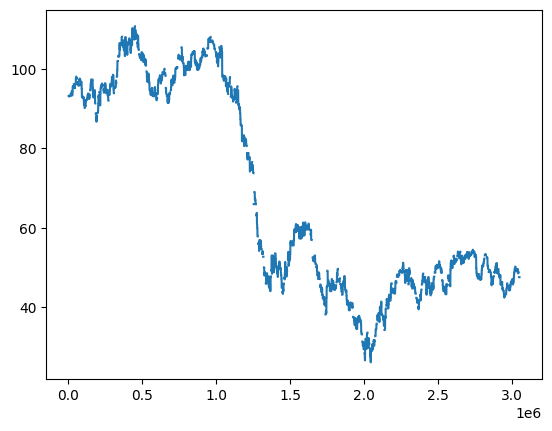

In [27]:
# check the oil_price column to see the best way to fill it missing values.

df4['oil_price'].plot()

Because of the of the downtrend of the column it will be best to fill it with backfill.

In [28]:
# Fill the missing values in the 'oil_price' column using backward fill.

df4['oil_price'].fillna(method='bfill', inplace=True)

In [29]:
# Create the 'holiday_status' column

# Function to map holiday type to holiday status
def map_holiday_status(holiday_type):
    if holiday_type in ['No holiday', 'Work Day']:
        return 'No holiday'
    else:
        return 'Holiday'

# Add the 'holiday_status' column using the 'holiday_type' column
df4['holiday_status'] = df4['holiday_type'].apply(map_holiday_status)
df4.head()

,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,transferred,oil_price,city,state,store_type,cluster,holiday_status
0,2013-01-01,1,AUTOMOTIVE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday
1,2013-01-01,1,BABY CARE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday
2,2013-01-01,1,BEAUTY,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday
3,2013-01-01,1,BEVERAGES,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday
4,2013-01-01,1,BOOKS,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday


In [30]:
# # Change the datatype of the date column to datetime.

df4['date'] = pd.to_datetime(df4['date'])

# Confirm the data type of the date column.

df4['date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 3054348 entries, 0 to 3054347
Series name: date
Non-Null Count    Dtype         
--------------    -----         
3054348 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 23.3 MB


Because we are doing time series analysis it will be necessary to set date column as index column.

In [31]:
# Set date column as index column.

df4.set_index('date', inplace=True)

In [32]:
# Create time series featurs based on time series index.

def create_feature(df4):
    df4['weekday'] = df4.index.weekday
    df4['month'] = df4.index.month
    df4['quarter'] = df4.index.quarter 
    df4['year'] = df4.index.year
    return df4

In [33]:
# Run the feature creation on the dataset.
df4 = create_feature(df4)

# Check the feature creation.
create_feature(df4).head()


,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,transferred,oil_price,city,state,store_type,cluster,holiday_status,weekday,month,quarter,year
date,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday,1,1,1,2013
2013-01-01,1,BABY CARE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday,1,1,1,2013
2013-01-01,1,BEAUTY,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday,1,1,1,2013
2013-01-01,1,BEVERAGES,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday,1,1,1,2013
2013-01-01,1,BOOKS,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday,1,1,1,2013


In [34]:
df4.describe().T

,count,mean,std,min,25%,50%,75%,max
store_nbr,3054348.0,27.500000,15.585787,1.000000,14.000000,27.500000,41.000000,54.000000
sales,3054348.0,359.020892,1107.285897,0.000000,0.000000,11.000000,196.011000,124717.000000
onpromotion,3054348.0,2.617480,12.254939,0.000000,0.000000,0.000000,0.000000,741.000000
transactions,3054348.0,1558.655862,1036.467605,0.000000,931.000000,1332.000000,1980.000000,8359.000000
oil_price,3054348.0,67.789300,25.702576,26.190001,46.279999,53.189999,95.800003,110.620003
cluster,3054348.0,8.481481,4.649735,1.000000,4.000000,8.500000,13.000000,17.000000
weekday,3054348.0,3.008168,2.001442,0.000000,1.000000,3.000000,5.000000,6.000000
month,3054348.0,6.222870,3.374251,1.000000,3.000000,6.000000,9.000000,12.000000
quarter,3054348.0,2.413652,1.095690,1.000000,1.000000,2.000000,3.000000,4.000000
year,3054348.0,2014.842474,1.345607,2013.000000,2014.000000,2015.000000,2016.000000,2017.000000


- Sales have a wide range and high standard deviation, indicating significant variability in sales amounts.
- Onpromotion values are generally low, with most observations being zero, suggesting promotions might be infrequent or not widely utilized.
- Transactions also show high variability, with a mean of 1558.66 and a maximum of 8359.
- Oil prices range from 26.19 to 110.62, with a mean of 67.79, indicating fluctuations in the oil market during the observed period.

## Univariate, Bivariate and Multivariate Analysis

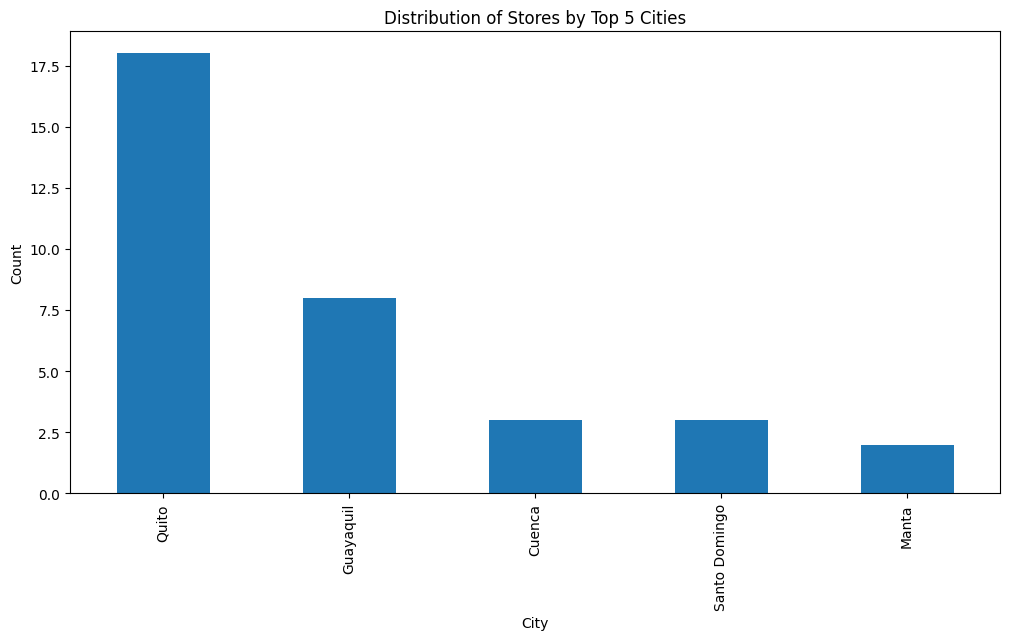

In [35]:
# Plotting the distribution of stores by top 5 cities
plt.figure(figsize=(12, 6))
stores['city'].value_counts().head(5).plot(kind='bar')
plt.xlabel('City')
plt.ylabel('Count')
plt.title('Distribution of Stores by Top 5 Cities')
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

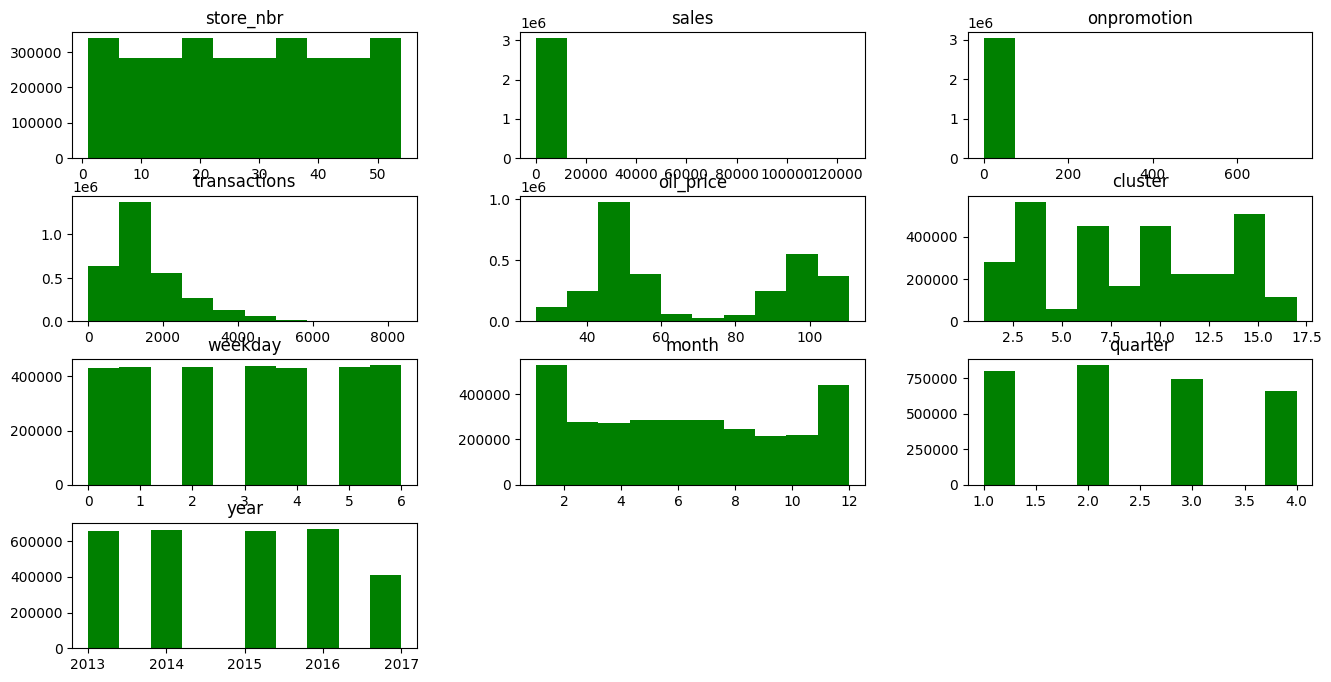

In [36]:
df4.hist(figsize=(16,8), grid=False, color = 'green')
plt.show

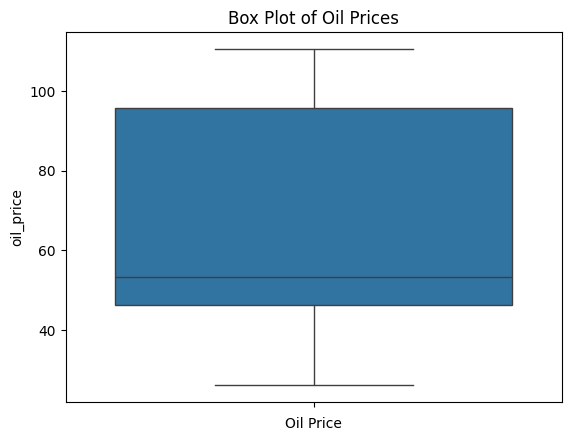

In [37]:
# Create the box plot of oil price to check outliers.
sns.boxplot(y=df4['oil_price'])

# Add title and labels
plt.title('Box Plot of Oil Prices')
plt.xlabel('Oil Price')

# Show the plot
plt.show()



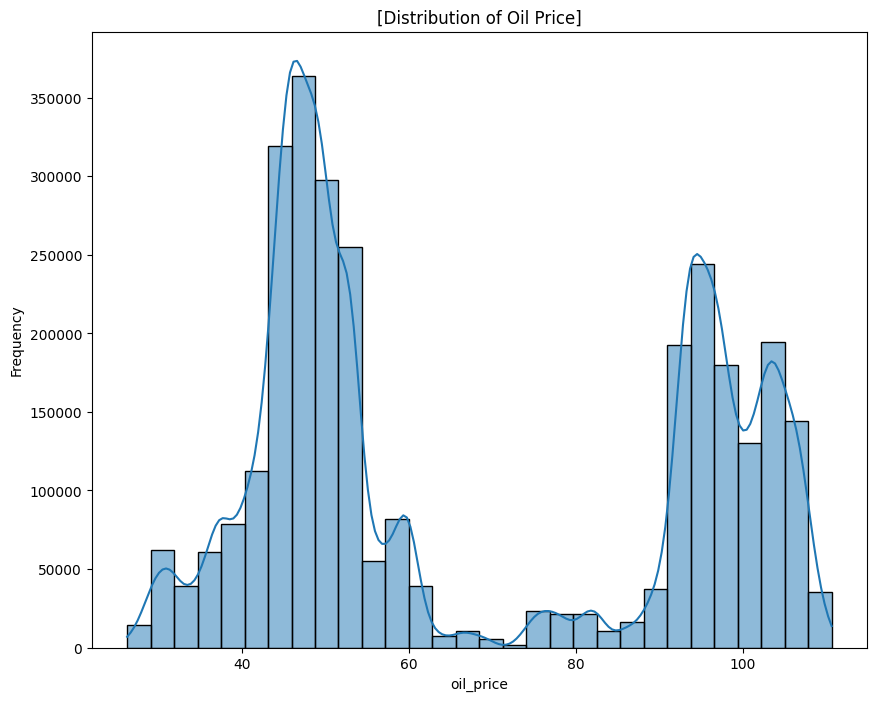

In [38]:
plt.figure(figsize=(10, 8))
sns.histplot(df4['oil_price'], bins=30, kde=True)
plt.title('[Distribution of Oil Price]')
plt.xlabel('oil_price')
plt.ylabel('Frequency')
plt.show()

In [39]:
correlation= df4.corr(numeric_only= True)

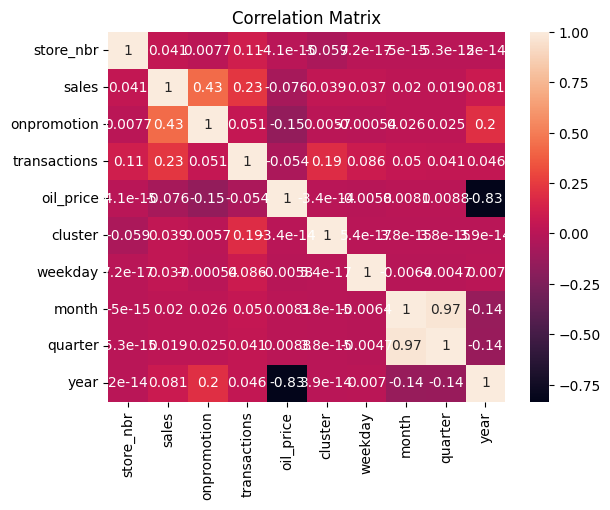

In [40]:
sns.heatmap(correlation, xticklabels= correlation.columns, yticklabels= correlation.columns, annot= True)
plt.title('Correlation Matrix')
plt.show()

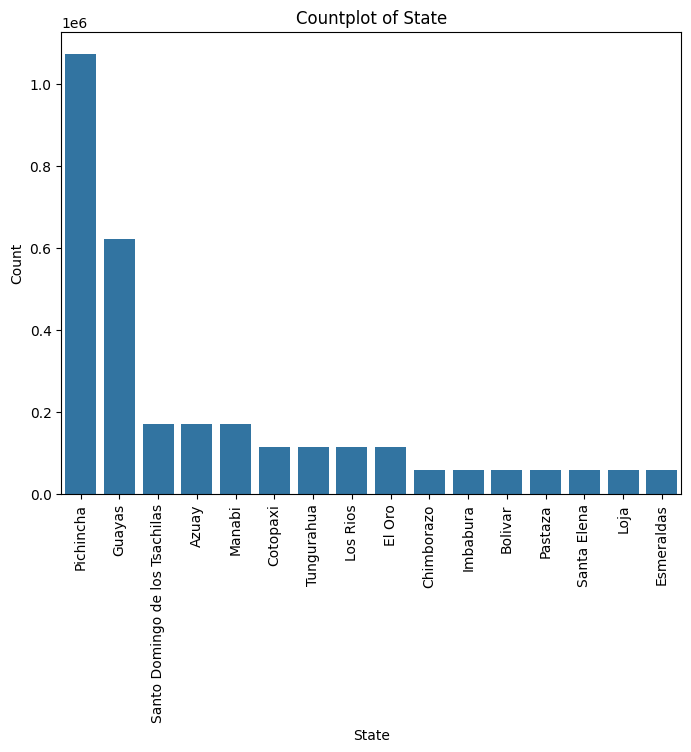

In [41]:

plt.figure(figsize=(8, 6))
sns.countplot(data=df4, x='state', order=df4['state'].value_counts().index)

plt.title('Countplot of State')
plt.xlabel('State')
plt.ylabel('Count')

plt.xticks(rotation=90) 
plt.show()




No outliers on the oil price

The histogram shows that most transactions fall within a certain range, around 800 to 1800, indicating a central trend. There is also a steady fall in the frequency of the transactions suggesting a steady transaction pattern.

The box plot shows that the transactions fall within a certain range, around 800 to 1800, indicating a central trend. There are a few outliers, especially in the lower range, suggesting that there might be some transactions that are significantly higher or lower than the rest of the data.

The time series plot shows a general upward trend in sales over the years, with sales peaking in 2016 and then declining in 2017. There are also some fluctuations in sales during the 2014 and 2015 holidays.

#### **Hypothesis Test**

In [42]:
# Null Hypothesis (H0): Holidays have impact on sales.
# Alternate Hypothesis (H1): Holidays do not have impact on sales.

# Group data by holiday status
holiday_sales = df4[df4['holiday_status'] == 'holiday']['sales']
non_holiday_sales = df4[df4['holiday_status'] == 'No holiday']['sales']

# Perform a t-test
t_stat, p_value = ttest_ind(holiday_sales, non_holiday_sales)

# Define the significance level
alpha = 0.05


if p_value < alpha:
    print("Reject the null hypothesis: Holidays have a significant impact on sales.")
else:
    print("Fail to reject the null hypothesis: Holidays do not have a significant impact on sales.")




Fail to reject the null hypothesis: Holidays do not have a significant impact on sales.


### **Analytical Questions**

In [43]:
#Is the train dataset complete (has all the required dates)?

df4['date'] = df4.index
# Get the minimum and maximum dates in the dataset
min_date = df4['date'].min()
max_date = df4['date'].max()

print(f"Date range in the dataset: {min_date} to {max_date}")

#Get a complete list of dates within the range 
complete_date_range= pd.date_range(start=min_date, end=max_date)

# Get the unique dates present in the dataset
present_dates = df4['date'].unique()

# Find missing dates by comparing the two lists
missing_dates = set(complete_date_range) - set(present_dates)

if not missing_dates:
    print("The train dataset is complete and contains all required dates.")
else:
    print("The train dataset is missing the following dates:")
    print(sorted(missing_dates))



Date range in the dataset: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
The train dataset is missing the following dates:
[Timestamp('2013-12-25 00:00:00'), Timestamp('2014-12-25 00:00:00'), Timestamp('2015-12-25 00:00:00'), Timestamp('2016-12-25 00:00:00')]


In [44]:
# Which dates have the lowest and highest sales for each year (excluding days the store was closed)?

# Filter out days with zero or missing sales
df_0 = df4[df4['sales'] > 0]

# Group by year and find dates with the lowest and highest sales
lowest_sales = df_0.loc[df_0.groupby('year')['sales'].idxmin()]
highest_sales = df_0.loc[df_0.groupby('year')['sales'].idxmax()]

# Print results
print("Dates with the Lowest Sales Each Year:")
print(lowest_sales[['year', 'date', 'sales']])

print("\nDates with the Highest Sales Each Year:")
print(highest_sales[['year', 'date', 'sales']])


Dates with the Lowest Sales Each Year:
            year       date     sales
date                                 
2013-08-06  2013 2013-08-06     2.000
2013-08-06  2013 2013-08-06     4.000
2013-08-06  2013 2013-08-06   886.000
2013-08-06  2013 2013-08-06   260.333
2013-08-06  2013 2013-08-06   548.000
...          ...        ...       ...
2017-02-09  2017 2017-02-09   291.967
2017-02-09  2017 2017-02-09   113.582
2017-02-09  2017 2017-02-09  1393.089
2017-02-09  2017 2017-02-09     2.000
2017-02-09  2017 2017-02-09     7.000

[6513 rows x 3 columns]

Dates with the Highest Sales Each Year:
            year       date     sales
date                                 
2013-11-12  2013 2013-11-12     1.000
2013-11-12  2013 2013-11-12     1.000
2013-11-12  2013 2013-11-12   819.000
2013-11-12  2013 2013-11-12   262.832
2013-11-12  2013 2013-11-12   525.000
...          ...        ...       ...
2017-04-02  2017 2017-04-02   621.062
2017-04-02  2017 2017-04-02   229.181
2017-04-02  2017 2017

In [45]:

# Compare the sales for each month across the years and determine which month of which year had the highest sales.

monthly_sales = df4.groupby(['year', 'month'])['sales'].sum().reset_index()

# Find the month with the highest sales for each year
highest_sales_per_year = monthly_sales.loc[monthly_sales.groupby('year')['sales'].idxmax()]

print("Month with the Highest Sales for Each Year:")
print(highest_sales_per_year)

# Find the overall highest sales month across all years
highest_sales_overall = monthly_sales.loc[monthly_sales['sales'].idxmax()]

print("\nMonth with the Highest Sales Overall:")
print(highest_sales_overall)


Month with the Highest Sales for Each Year:
    year  month         sales
11  2013     12  1.649941e+07
23  2014     12  2.622070e+07
35  2015     12  2.838584e+07
47  2016     12  3.077614e+07
54  2017      7  2.793662e+07

Month with the Highest Sales Overall:
year     2.016000e+03
month    1.200000e+01
sales    3.077614e+07
Name: 47, dtype: float64


In [46]:
# Did the earthquake impact sales?


# Date of earthquake
earthquake_date = pd.Timestamp('2016-04-16')

# Split the data into before and after the earthquake
before = df4[df4['date'] < earthquake_date]
after = df4[df4['date'] >= earthquake_date]

# Compare sales before and after the earthquake
mean_sales_before = before['sales'].mean()
mean_sales_after = after['sales'].mean()

print(f"Mean sales before the earthquake: {mean_sales_before}")
print(f"Mean sales after the earthquake: {mean_sales_after}")

# Conduct a t-test to compare the means
t_stat, p_value = ttest_ind(before['sales'], after['sales'], equal_var=False)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


Mean sales before the earthquake: 314.7514160421047
Mean sales after the earthquake: 466.20427477007996
T-statistic: -96.03209079650537
P-value: 0.0


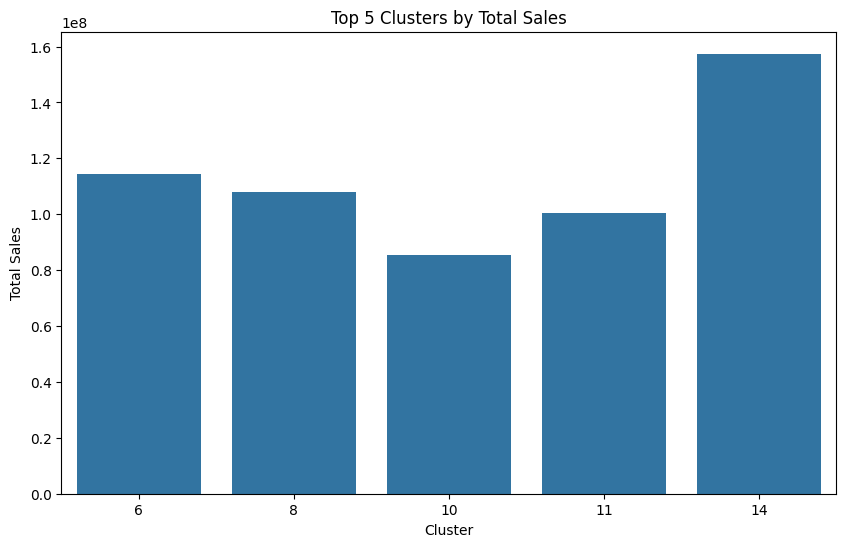

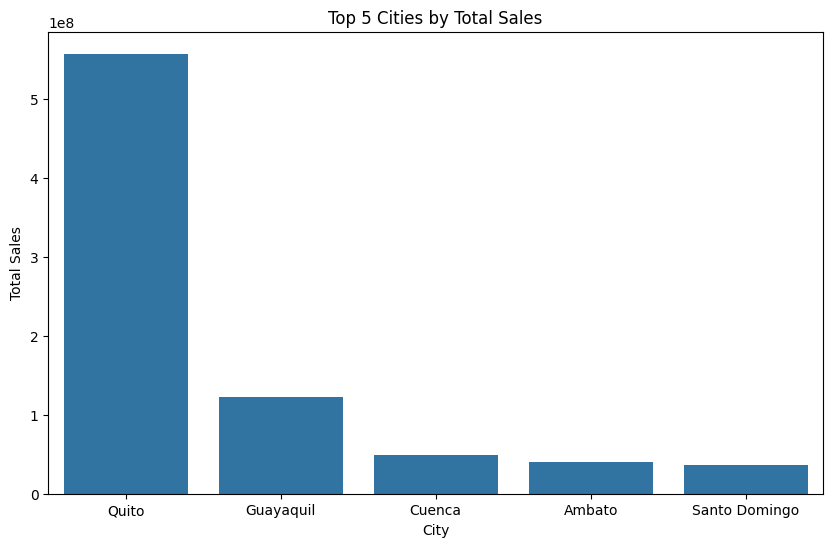

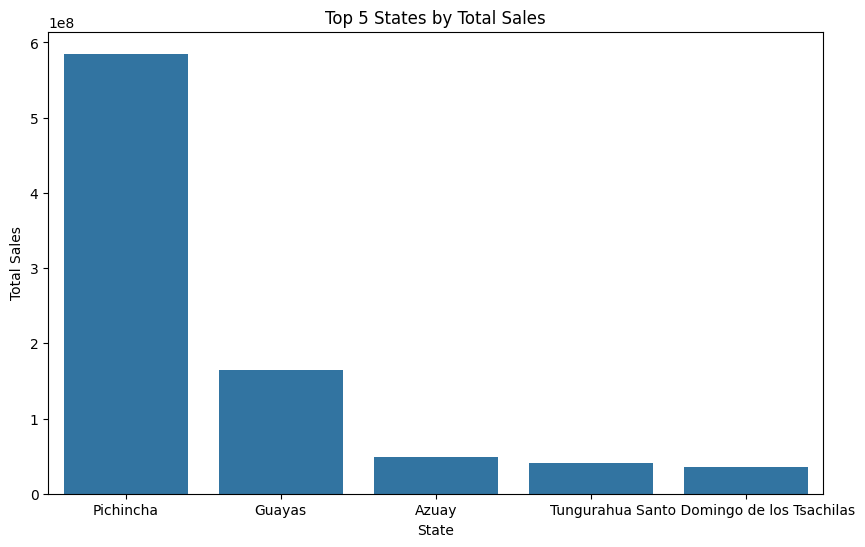

In [52]:
# Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
df_merged = pd.merge(train, stores, on='store_nbr', how='left')

sales_by_cluster = df_merged.groupby('cluster')['sales'].sum().reset_index()
top_clusters = sales_by_cluster.nlargest(5, 'sales')
plt.figure(figsize=(10, 6))
sns.barplot(data=top_clusters, x='cluster', y='sales')
plt.title('Top 5 Clusters by Total Sales')
plt.xlabel('Cluster')
plt.ylabel('Total Sales')
plt.show()

sales_by_city = df_merged.groupby('city')['sales'].sum().reset_index()
top_cities = sales_by_city.nlargest(5, 'sales')
plt.figure(figsize=(10, 6))
sns.barplot(data=top_cities, x='city', y='sales')
plt.title('Top 5 Cities by Total Sales')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.show()


sales_by_state = df_merged.groupby('state')['sales'].sum().reset_index()
top_states = sales_by_state.nlargest(5, 'sales')
plt.figure(figsize=(10, 6))
sns.barplot(data=top_states, x='state', y='sales')
plt.title('Top 5 States by Total Sales')
plt.xlabel('State')
plt.ylabel('Total Sales')
plt.show()





Average Sales by Promotion Status:
  on_promotion        sales
0           No   158.246681
1          Yes  1137.693730


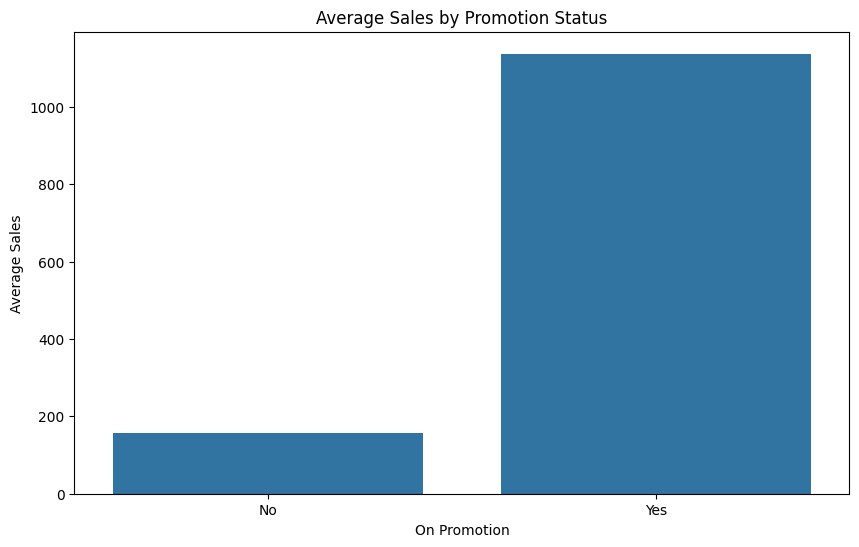

In [53]:
# Are sales affected by promotions, oil prices and holidays?

# Promotions Analysis
df_merged['on_promotion'] = df_merged['onpromotion'].apply(lambda x: 'Yes' if x > 0 else 'No')
promotion_sales = df_merged.groupby('on_promotion')['sales'].mean().reset_index()

print("Average Sales by Promotion Status:")
print(promotion_sales)

plt.figure(figsize=(10, 6))
sns.barplot(data=promotion_sales, x='on_promotion', y='sales')
plt.title('Average Sales by Promotion Status')
plt.xlabel('On Promotion')
plt.ylabel('Average Sales')
plt.show()



Correlation between oil prices and sales: -0.07905016002353672


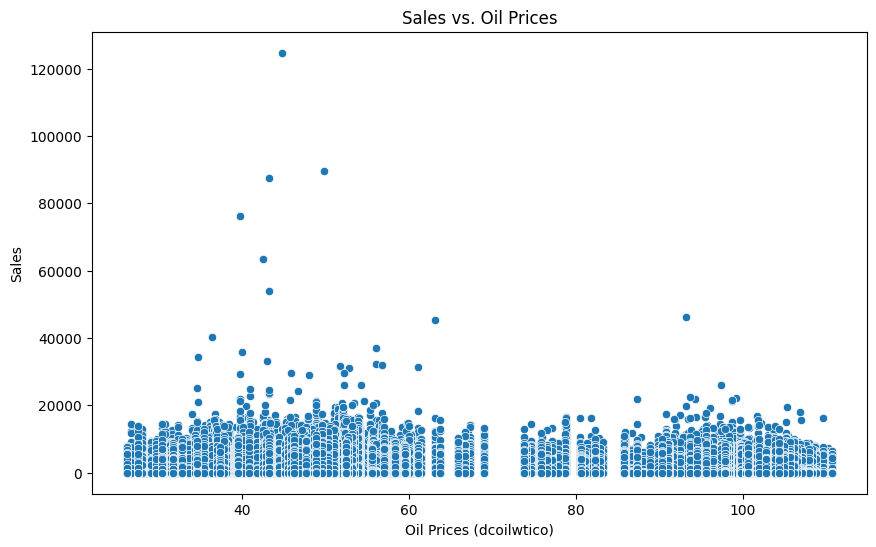

In [54]:
# Oil Prices Analysis
df_merged = pd.merge(df_merged, oil, on='date', how='left')
correlation = df_merged[['dcoilwtico', 'sales']].corr().iloc[0, 1]
print(f"Correlation between oil prices and sales: {correlation}")

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_merged, x='dcoilwtico', y='sales')
plt.title('Sales vs. Oil Prices')
plt.xlabel('Oil Prices (dcoilwtico)')
plt.ylabel('Sales')
plt.show()




## Data Preparation and Modelling